In [2]:
import os
import numpy as np
from PIL import Image
#data visualization
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
labels = ['PNEUMONIA', 'NORMAL']
resample_size = 180
img_size = 150
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# Ensure deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
def center_crop(img, crop_size):
    """
    Crops the center of a PIL image.

    Args:
        img (PIL.Image): Image to crop.
        crop_size (int or tuple): Size of the crop (width, height). If int, assumed square.

    Returns:
        PIL.Image: Cropped image.
    """
    if isinstance(crop_size, int):
        crop_size = (crop_size, crop_size)

    width, height = img.size
    new_width, new_height = crop_size

    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = left + new_width
    bottom = top + new_height

    return img.crop((left, top, right, bottom))
def get_training_data(data_dir):
    """
    Processes images from the specified directory, assigns labels, and outputs the dataset.

    Args:
        data_dir (str): Path to the directory containing labeled subfolders.

    Returns:
        np.ndarray: A NumPy array containing the processed images and their labels.
    """
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                with Image.open(img_path) as img_obj:
                    img_obj = img_obj.convert('L')  # Convert to grayscale
                    # Step 1: Resize to 200x200
                    resized = img_obj.resize((resample_size, resample_size), Image.Resampling.LANCZOS)

                    # Step 2: Center crop to 160x160
                    cropped = center_crop(resized, img_size)

                    data.append([np.array(cropped), class_num])
            except Exception as e:
                print(f"Skipping file {img}: {e}")
    return np.array(data, dtype=object)


train = get_training_data('../../data/chest_xray/train')
validation = get_training_data('../../data/chest_xray/val')
test = get_training_data('../../data/chest_xray/test')
print('train shape:', train.shape)
print('train', train[0])

# Randomly permute the labels of the training data
# permuted_indices = np.random.permutation(len(train))
# train = [(train[i][0], train[permuted_indices[i]][1]) for i in range(len(train))]


Skipping file .DS_Store: cannot identify image file '../../data/chest_xray/train/PNEUMONIA/.DS_Store'
Skipping file .DS_Store: cannot identify image file '../../data/chest_xray/train/NORMAL/.DS_Store'
Skipping file .DS_Store: cannot identify image file '../../data/chest_xray/val/PNEUMONIA/.DS_Store'
Skipping file .DS_Store: cannot identify image file '../../data/chest_xray/val/NORMAL/.DS_Store'
train shape: (5216, 2)
train [array([[ 96,  93,  95, ...,  67,  58,  49],
        [ 95,  96,  94, ...,  66,  62,  53],
        [ 93,  93,  96, ...,  64,  63,  59],
        ...,
        [ 88,  92, 112, ...,   0,   0,   1],
        [ 87,  94, 121, ...,   0,   0,   1],
        [ 87,  98, 126, ...,   0,   0,   1]], dtype=uint8) 0]


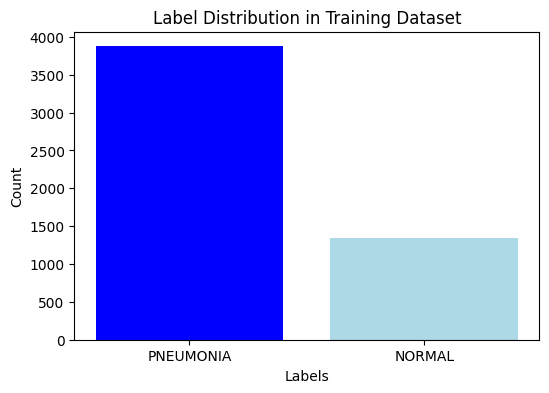

In [3]:


# Extract labels from the training data
label_counts = [sample[1] for sample in train]

# Visualize the label distribution
plt.figure(figsize=(6, 4))
plt.bar(labels, [label_counts.count(i) for i in range(len(labels))], color=['blue', 'lightblue'])
plt.title('Label Distribution in Training Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

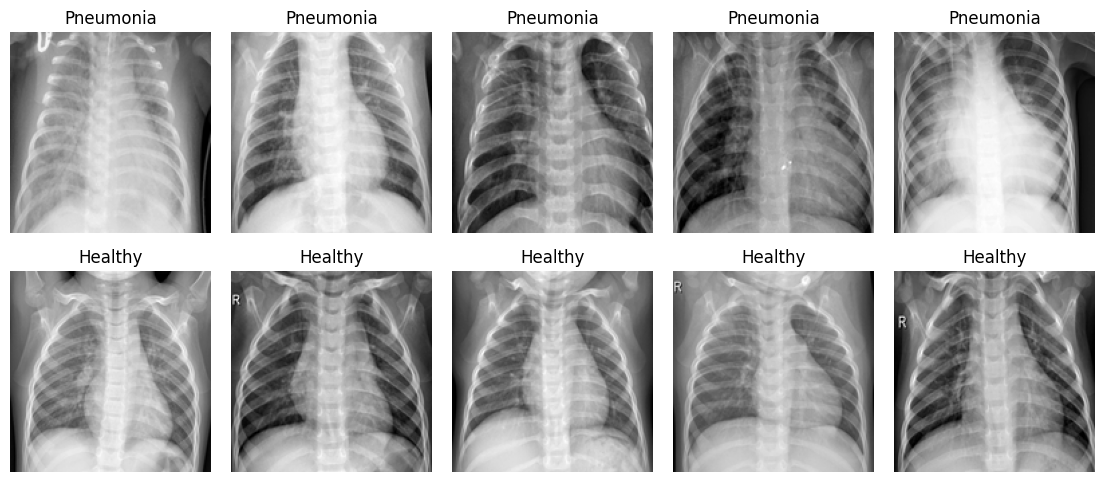

In [4]:
# Find five examples of each label
pneumonia_examples = [sample[0] for sample in train if sample[1] == 0][:5]
normal_examples = [sample[0] for sample in train if sample[1] == 1][:5]

# Plot the examples
plt.figure(figsize=(14, 10))

# PNEUMONIA examples
for i, example in enumerate(pneumonia_examples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(example, cmap='gray')
    plt.title('Pneumonia')
    plt.axis('off')

# NORMAL examples
for i, example in enumerate(normal_examples):
    plt.subplot(2, 5, i + 6)
    plt.imshow(example, cmap='gray')
    plt.title('Healthy')
    plt.axis('off')

# plt.tight_layout()
plt.subplots_adjust(hspace=-0.55, wspace=0.1)  # smaller hspace = less vertical gap
plt.show()

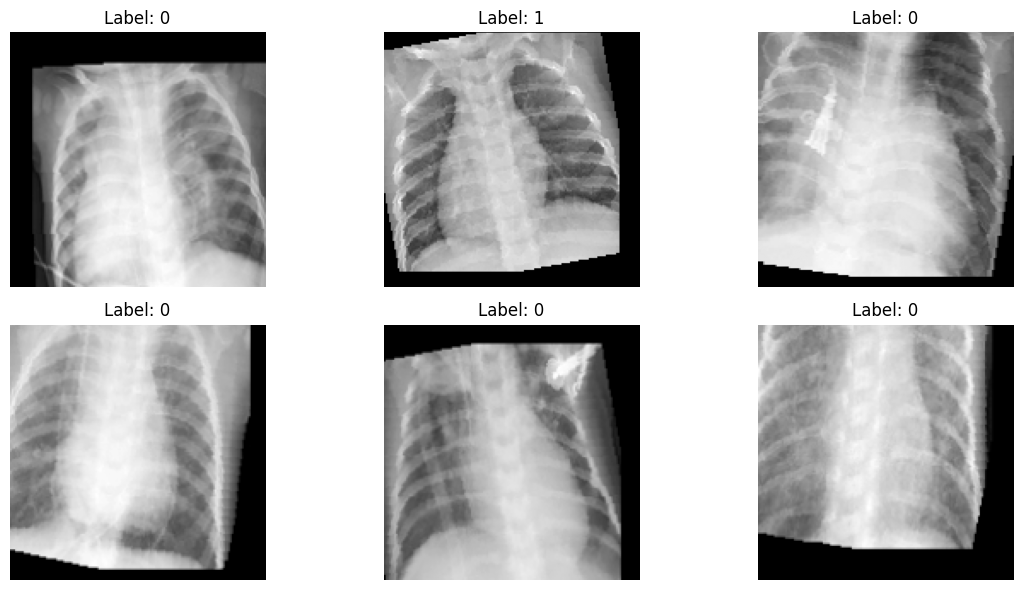

Total parameters: 1245313
Trainable parameters: 1245313
Current Learning Rate: 0.0005
Predicted Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]
True Labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 1/10, Train Loss: 0.28196557245554366, Validation Loss: 0.6189190149307251, Validation Accuracy: 68.75%
Current Learning Rate: 0.0005
Predicted Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
True Labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 2/10, Train Loss: 0.18414572441230523, Validation Loss: 1.6770408153533936, Validation Accuracy: 62.5%
Current Learning Rate: 0.0005
Predicted Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
True Labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Epoch 3/10, Train Loss: 0.16168147172390318, Validation Loss: 1.1016881465911865, Validation Accuracy: 62.5%
Current Learning Rate: 0.0005
Predicted Lab

In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score

train_transforms = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # shift and zoom
    transforms.RandomResizedCrop(size=150, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.ToTensor()
])

# Prepare the data
class PneumoniaDataset(Dataset):
    def __init__(self, data, transform = None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image, label = self.data[idx]

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) 
            label = torch.tensor(label, dtype=torch.long)
        return image, label

# Normalize the samples by dividing by 255
# train = [(image / 255.0, label) for image, label in train]
validation_normalized = [(image / 255.0, label) for image, label in validation]
test_normalized = [(image / 255.0, label) for image, label in test]

# Create dataset and split into training and validation sets
train_dataset = PneumoniaDataset(train, transform=train_transforms)
val_dataset = PneumoniaDataset(validation_normalized)
test_dataset = PneumoniaDataset(test_normalized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Helper function to unnormalize and display images
def imshow(img_tensor):
    img = img_tensor.numpy()
    plt.imshow(img[0], cmap='gray')
    plt.axis('off')

# Get one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first 6 images in the batch
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    imshow(images[i].cpu())
    plt.title(f"Label: {labels[i].item()}")
plt.tight_layout()
plt.show()
# Define the CNN model
class CNN(nn.Module):
    def _get_conv_output(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.conv_layers(x)
            return x.view(1, -1).size(1)
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
        )
        flattened_size = self._get_conv_output((1, 150, 150))  # channel=1 for grayscale

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

scheduler = ReduceLROnPlateau(optimizer, 
                              mode='max',      # 'max' for maximizing validation accuracy
                              factor=0.1,      # Reduce learning rate by a factor of 0.3
                              patience=2,      # Wait for 2 epochs before reducing LR
                              min_lr=1e-6)     # Minimum learning rate


# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
# Train the model
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']}")
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()  # Convert labels to float for BCEWithLogitsLoss
        optimizer.zero_grad()
        outputs = model(images).squeeze(1)  # Squeeze the output to match the label shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Perform validation after each epoch
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()  # Convert labels to float for BCEWithLogitsLoss
            outputs = model(images).squeeze(1)  # Squeeze the output to match the label shape
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).long()  # Apply sigmoid and threshold for binary classification
            total += labels.size(0)
            correct += (predicted == labels.long()).sum().item()
            print(f"Predicted Labels: {predicted.tolist()}")
            print(f"True Labels: {labels.tolist()}")

    val_loss_for_scheduler = 100 * correct / total
    scheduler.step(val_loss_for_scheduler)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {100 * correct / total}%")

# Evaluate the model on the test set
model.eval()
test_loss = 0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()  # Convert labels to float for BCEWithLogitsLoss
        outputs = model(images).squeeze(1)  # Squeeze the output to match the label shape
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).long()  # Apply sigmoid and threshold for binary classification
        total += labels.size(0)
        correct += (predicted == labels.long()).sum().item()
        
        # Collect all labels and predictions for AUROC and AUPRC
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
        
        print(f"Predicted Labels: {predicted.tolist()}")
        print(f"True Labels: {labels.tolist()}")

# Calculate AUROC and AUPRC
auroc = roc_auc_score(all_labels, all_predictions)
auprc = average_precision_score(all_labels, all_predictions)

print(f"Test Loss: {test_loss/len(test_loader)}")
print(f"Test Accuracy: {100 * correct / total}%")
print(f"Test AUROC: {auroc}")
print(f"Test AUPRC: {auprc}")


Test Loss: 0.4058
Test Accuracy: 88.62%


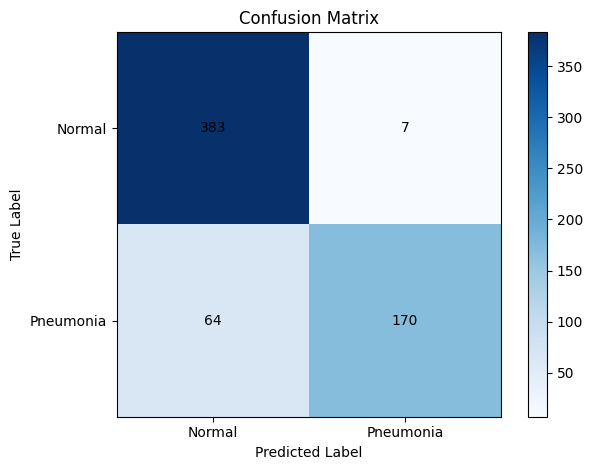

Classification Report:
              precision    recall  f1-score   support

      Normal       0.86      0.98      0.92       390
   Pneumonia       0.96      0.73      0.83       234

    accuracy                           0.89       624
   macro avg       0.91      0.85      0.87       624
weighted avg       0.90      0.89      0.88       624



In [6]:


# Evaluation
model.eval()
test_loss = 0
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = (torch.sigmoid(outputs) > 0.5).long()
        total += labels.size(0)
        correct += (preds == labels.long()).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix manually
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Add labels
classes = ["Normal", "Pneumonia"]
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.colorbar(im)
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"]))


/mnt/c/Users/Elias/OneDrive - ETH Zurich/2025SS/Machine Learning for Healthcare/MLH4-Project-2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


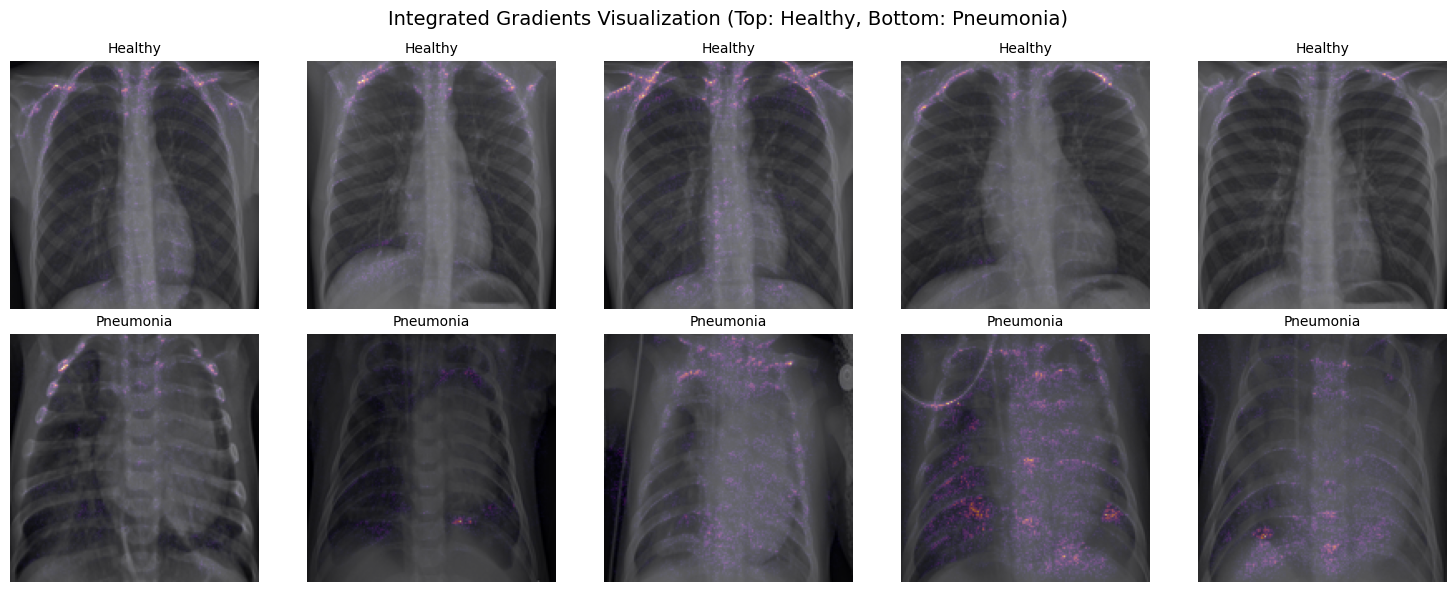

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)

from scipy.ndimage import gaussian_filter

def get_attr_overlay(image, label, baseline=None, blur_sigma=0.5, alpha=0.5):
    image = image.unsqueeze(0).to(device)
    label = label.to(device)

    # Baseline can be gray or slight noise
    if baseline is None:
        baseline = torch.full_like(image, 0.5)

    attributions, _ = ig.attribute(image, baseline, target=None, return_convergence_delta=True)

    # Process image and attributions
    original = image.squeeze().cpu().numpy()
    attr = attributions.squeeze().cpu().detach().numpy()

    # Normalize attribution
    attr = np.abs(attr)  # optional: focus on magnitude
    attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

    # Blur attribution for smoother overlay
    if blur_sigma:
        attr = gaussian_filter(attr, sigma=blur_sigma)

    # Create a background grayscale image
    background = np.stack([original] * 3, axis=-1)  # grayscale to RGB
    background = np.clip(background, 0, 1)

    return background, attr, alpha


# Collect 5 from each class
samples_to_visualize = {'PNEUMONIA': [], 'NORMAL': []}
for img, label in test_dataset:
    label_name = 'PNEUMONIA' if label == 0 else 'NORMAL'
    if len(samples_to_visualize[label_name]) < 5:
        samples_to_visualize[label_name].append((img, label))
    if all(len(v) == 5 for v in samples_to_visualize.values()):
        break

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

# NORMAL
for col, (img_tensor, label) in enumerate(samples_to_visualize['NORMAL']):
    bg, attr, alpha = get_attr_overlay(img_tensor, label)
    ax = axes[0, col]
    ax.imshow(bg, cmap='gray')
    ax.imshow(attr, cmap='inferno', alpha=alpha)
    ax.set_title("Healthy", fontsize=10)
    ax.axis('off')

# PNEUMONIA
for col, (img_tensor, label) in enumerate(samples_to_visualize['PNEUMONIA']):
    bg, attr, alpha = get_attr_overlay(img_tensor, label)
    ax = axes[1, col]
    ax.imshow(bg, cmap='gray')
    ax.imshow(attr, cmap='inferno', alpha=alpha)
    ax.set_title("Pneumonia", fontsize=10)
    ax.axis('off')

plt.suptitle("Integrated Gradients Visualization (Top: Healthy, Bottom: Pneumonia)", fontsize=14)
plt.tight_layout()
plt.show()



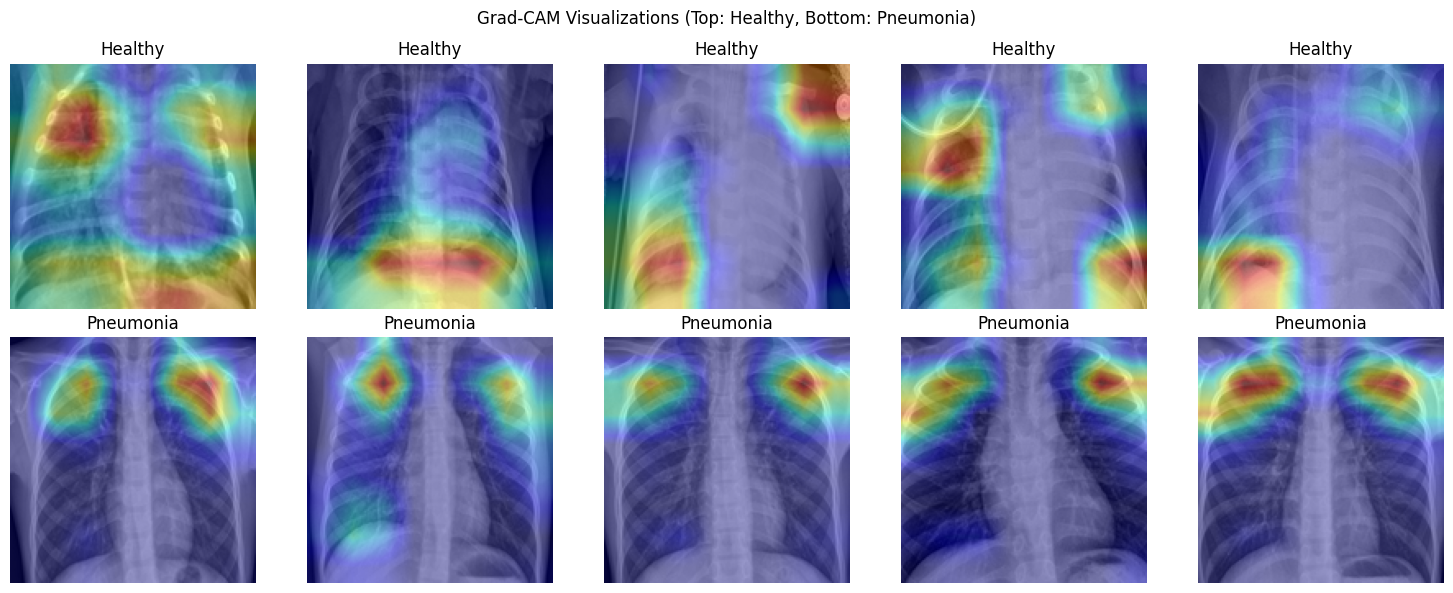

In [8]:
# Grad-CAM hook class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer

        # Placeholders for gradients and activations
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, target_class):
        self.model.zero_grad()
        output = self.model(input_tensor)
        loss = output[:, 0]  # assuming binary classification

        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # global average pooling
        cam = torch.sum(weights * self.activations, dim=1)  # weighted sum
        cam = F.relu(cam)  # only positive influence

        # Resize CAM to match input image size
        cam = F.interpolate(cam.unsqueeze(1), size=(img_size, img_size), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # normalize
        return cam

# Setup
target_layer = model.conv_layers[-4]  # Choose a deep layer like last conv layer
gradcam = GradCAM(model, target_layer)

def visualize_gradcam(image_tensor, cam, title=""):
    image = image_tensor.squeeze().cpu().numpy()
    plt.imshow(image, cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.4)
    plt.axis('off')
    plt.title(title)

# Select samples from test set
samples_to_visualize = {'Healthy': [], 'Pneumonia': []}
for img, label in test_dataset:
    label_name = 'Pneumonia' if label == 1 else 'Healthy'
    if len(samples_to_visualize[label_name]) < 5:
        samples_to_visualize[label_name].append((img.unsqueeze(0).to(device), label))
    if all(len(v) == 5 for v in samples_to_visualize.values()):
        break

# Plotting
plt.figure(figsize=(15, 6))
i = 1
for label, samples in samples_to_visualize.items():
    for img_tensor, _ in samples:
        cam = gradcam.generate_cam(img_tensor, target_class=1)
        plt.subplot(2, 5, i)
        visualize_gradcam(img_tensor, cam, title=label)
        i += 1
plt.suptitle("Grad-CAM Visualizations (Top: Healthy, Bottom: Pneumonia)")
plt.tight_layout()
plt.show()
